# SiMFS-Tk Example: Pulsed excitation

This example demonstrates the usage of ``simfs_pls`` to generate pulse patterns based on cw excitation stream.

### Components

- ``simfs_dif``
- ``simfs_exi``
- ``simfs_pls``

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from pysimfs import *

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


### Creating cw excitation

We create a short diffusion path and evaluate a standard focus function on it:

In [2]:
with Simulation() as S:
    S.add(Diffusion(experiment_time=10e-7, coordinate_output='coords', collision_output=os.devnull))
    S.add(Excitation(input='coords', output='exi_cw.dat'))
    log = S.run()
    cw = S.get_results()['exi_cw.dat']

Folder ./pysimfs_data exists.
Started simulation with 2 component processes.
Simulation completed after 0.08 seconds.


### Inspecting the cw data

We use a step plot to show the individual excitation values for each time-interval in the simulation. The markers are the actual data points, the step line represents the interval in which a value is valid. You see a step curve with 100 ns resolution.

(0, 5.60826068422695e+23)

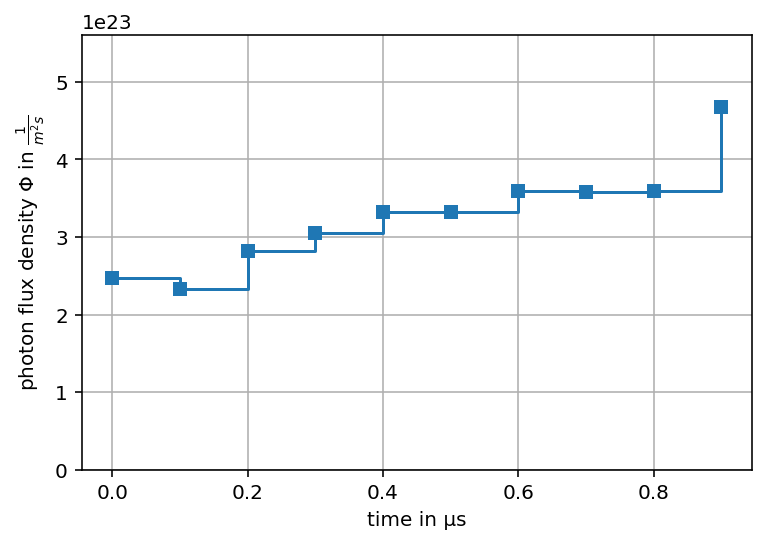

In [3]:
plt.step(cw['t']*1e+6, cw['v'], where='post', marker='s')
plt.grid()
plt.xlabel('time in µs')
plt.ylabel(r'photon flux density $\Phi$ in $\frac{1}{m^2 s}$')
plt.ylim(0, cw['v'].max()*1.2)

### Building a pulse pattern

We can now apply a pulse patter to the cw excitation data. We need a repitition time to define the pulse window, a time and a power axis. Times are relative to the pulse window. Power values are relative: ``simfs_pls`` will take the power level from its input data and redistribute it to the pulse window in that way, that the total power is retained. In other words the pulse shape area will be normalized.

In [4]:
# %simfs_default pls
pls_params = {
    'input': 'exi_cw.dat',
    'output': 'exi_pulsed.dat',
    'power': [0, 1, 0],
    'repetition_time': 1e-07,
    'time': [0, 1e-9, 10e-9]
}

Running the parameters through ``simfs_pls`` allows us to take a look at the normalization.

In [5]:
pls_params_norm = Pulse(**pls_params).params

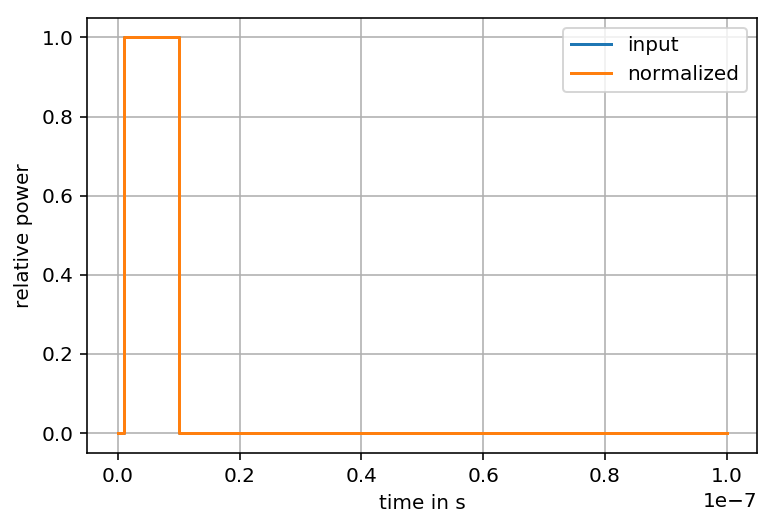

In [6]:
for pls, label in zip((pls_params, pls_params_norm), ('input', 'normalized')):
    time = pls['time'] + [pls['repetition_time']]
    power = pls['power'] +[pls['power'][-1]]
    plt.step(time, power, where='post', label=label)
    
plt.xlabel('time in s')
plt.ylabel('relative power')
plt.grid()
plt.legend()

### Running the pulse

Running the pulse over the cw exctitaion data gets us the pulse pattern put on top of the diffusion excitation trace.

In [7]:
with Simulation() as S:
    S.add(Pulse(**pls_params))
    log = S.run()
    pulse = S.get_results()['exi_pulsed.dat']

Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 0.04 seconds.


(0, 6.231400760252167e+24)

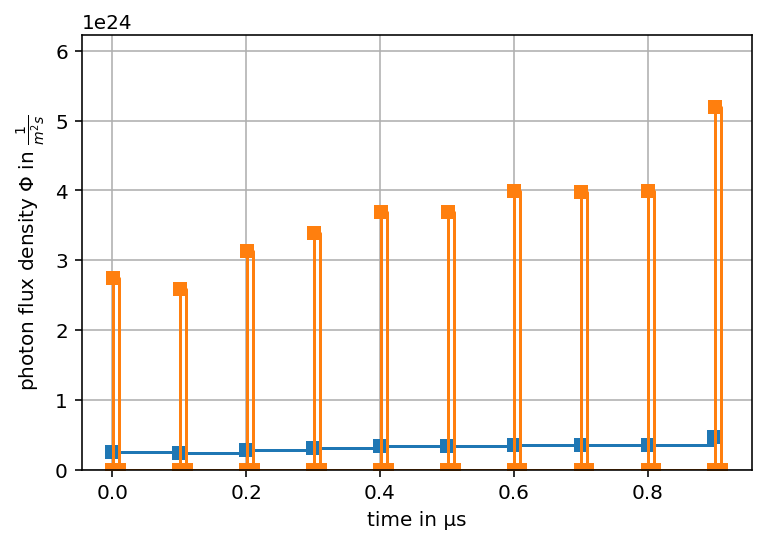

In [8]:
plt.step(cw['t']*1e+6, cw['v'], where='post', marker='s')
plt.step(pulse['t']*1e+6, pulse['v'], where='post', marker='s')
plt.grid()
plt.xlabel('time in µs')
plt.ylabel(r'photon flux density $\Phi$ in $\frac{1}{m^2 s}$')
plt.ylim(0, pulse['v'].max()*1.2)

### Remarks

The resulting excitation pattern combines the diffusive and laser pulse fluctuation. A fluorophore that consumes this data will be updated at according to the two processes.

**Note:**

Creating pulses multiplies the amount of excitation trace data by the number of pulse shape points. Complex patterns can lead to significant slow down since the update procedure in the downstream Fluorophore instance is preformed more often. Build pulse patterns as simple as possible.